### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data augmentation and normalization
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=4)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = models.resnet18(weights=None)
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(model.fc.in_features, 100)  # 100 classes for CIFAR-100

checkpoint = torch.load('best_resnet18_cifar100.pth')
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Targeted PGD Attack

In [29]:
def pgd_attack(model, images, labels, target_labels, epsilon=16/255, alpha=4/255, iters=40):
    """
    PGD attack with proper gradient tracking.
    
    Args:
        model: The model to attack
        images: Clean images
        labels: True labels
        target_labels: Target labels for the attack
        epsilon: Maximum perturbation
        alpha: Step size
        iters: Number of iterations
        
    Returns:
        Adversarial images
    """
    # Ensure we're working with a device-consistent copy
    device = next(model.parameters()).device
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    target_labels = target_labels.to(device)
    criterion = nn.CrossEntropyLoss()

    # Initialize adversarial images
    adv_images = images.clone().detach()

    for i in range(iters):
        # Important: Create a fresh copy that requires gradients
        adv_images = adv_images.detach().requires_grad_(True)
        
        # Forward pass
        outputs = model(adv_images)
        loss = criterion(outputs, target_labels)
        
        # Backward pass
        model.zero_grad()
        loss.backward()
        
        # Get gradients
        grad = adv_images.grad.detach()
        
        # Update adversarial images
        with torch.no_grad():
            adv_images = adv_images - alpha * grad.sign()  # Perturb toward target
            delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
            adv_images = torch.clamp(images + delta, min=0, max=1)

        # Optional debugging
        if i % 10 == 0:
            print(f"Iteration {i}, Loss: {loss.item():.4f}")

    return adv_images.detach()

In [30]:
def evaluate_full_test(model, testloader, epsilon=16/255, alpha=4/255, iters=20, subset_size=None):
    """
    Evaluates the model on clean and adversarial examples.
    """
    model.eval()
    clean_correct = 0
    adv_correct = 0
    total = 0

    # If subset_size is specified, limit the evaluation
    if subset_size:
        # Make sure testset is defined before using it
        # If not defined, use a subset of testloader
        try:
            subset_loader = torch.utils.data.DataLoader(
                testset, batch_size=256, shuffle=True, num_workers=4
            )
        except NameError:
            # Create a subset from existing loader
            subset_loader = testloader
        max_batches = subset_size // 256 + 1
    else:
        subset_loader = testloader
        max_batches = len(testloader)

    for i, (images, labels) in enumerate(subset_loader):
        if i >= max_batches:
            break
            
        images, labels = images.to(device), labels.to(device)
        total += labels.size(0)

        # Clean accuracy (without gradients)
        with torch.no_grad():
            outputs = model(images)
            _, predicted = outputs.max(1)
            clean_correct += predicted.eq(labels).sum().item()

        # Generate adversarial examples (requires gradients)
        target_labels = (labels + 1) % 100  # Example: shift to next class
        adv_images = pgd_attack(model, images, labels, target_labels, epsilon, alpha, iters)

        # Adversarial accuracy (without gradients)
        with torch.no_grad():
            adv_outputs = model(adv_images)
            _, adv_predicted = adv_outputs.max(1)
            adv_correct += adv_predicted.eq(target_labels).sum().item()

    clean_acc = 100. * clean_correct / total
    attack_success = 100. * adv_correct / total
    print(f"Clean Accuracy: {clean_acc:.2f}%")
    print(f"Attack Success Rate: {attack_success:.2f}%")
    return clean_acc, attack_success

In [33]:
clean_acc, attack_success = evaluate_full_test(model, test_loader, epsilon=40/255, alpha=2/255, iters=50)

Iteration 0, Loss: 13.7443
Iteration 10, Loss: 4.1365
Iteration 20, Loss: 2.0461
Iteration 30, Loss: 1.5456
Iteration 40, Loss: 1.3740
Iteration 0, Loss: 13.3273
Iteration 10, Loss: 3.6640
Iteration 20, Loss: 1.7172
Iteration 30, Loss: 1.2922
Iteration 40, Loss: 1.1521
Iteration 0, Loss: 13.7077
Iteration 10, Loss: 4.0665
Iteration 20, Loss: 2.0339
Iteration 30, Loss: 1.5855
Iteration 40, Loss: 1.4382
Iteration 0, Loss: 13.3137
Iteration 10, Loss: 4.1172
Iteration 20, Loss: 2.1520
Iteration 30, Loss: 1.7104
Iteration 40, Loss: 1.5524
Iteration 0, Loss: 13.8890
Iteration 10, Loss: 4.1400
Iteration 20, Loss: 2.0889
Iteration 30, Loss: 1.6009
Iteration 40, Loss: 1.4354
Iteration 0, Loss: 13.2399
Iteration 10, Loss: 3.8464
Iteration 20, Loss: 1.8514
Iteration 30, Loss: 1.4417
Iteration 40, Loss: 1.3042
Iteration 0, Loss: 13.4545
Iteration 10, Loss: 3.9440
Iteration 20, Loss: 1.9085
Iteration 30, Loss: 1.4640
Iteration 40, Loss: 1.3181
Iteration 0, Loss: 13.9408
Iteration 10, Loss: 4.1242
I

Iteration 0, Loss: 13.7443
Iteration 10, Loss: 4.4008
Iteration 20, Loss: 4.2023
Iteration 30, Loss: 4.1496


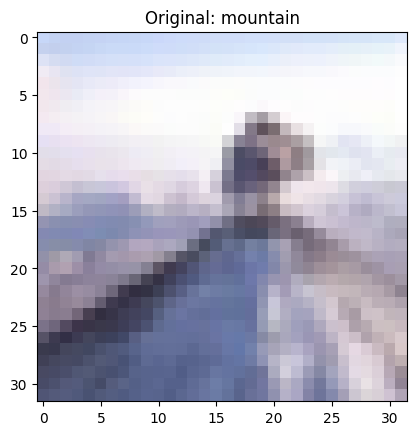

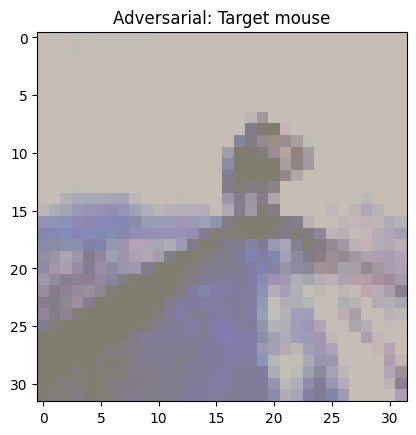

In [32]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
target_labels = (labels + 1) % 100
adv_images = pgd_attack(model, images, labels, target_labels)

def imshow(img, title):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.show()

imshow(images[0], f"Original: {testset.classes[labels[0]]}")
imshow(adv_images[0], f"Adversarial: Target {testset.classes[target_labels[0]]}")

### Untargeted PGD Attack

In [5]:
def improved_pgd_attack(model, images, labels, target_labels=None, epsilon=20/255, alpha=8/255, 
                       iters=100, random_start=True, untargeted=False):
    """
    Enhanced PGD attack with better performance.
    Works with any input tensor shape.
    """
    device = next(model.parameters()).device
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    
    if target_labels is not None:
        target_labels = target_labels.to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Initialize adversarial images
    adv_images = images.clone().detach()
    
    # Start with random noise within epsilon ball if requested
    if random_start:
        noise = torch.FloatTensor(images.shape).uniform_(-epsilon, epsilon).to(device)
        adv_images = adv_images + noise
        adv_images = torch.clamp(adv_images, 0, 1)
    
    best_adv_images = adv_images.clone()
    best_loss = None
    
    for i in range(iters):
        adv_images.requires_grad = True
        
        outputs = model(adv_images)
        
        # For untargeted attack, maximize loss on true label
        # For targeted attack, minimize loss on target label
        if untargeted:
            loss = -criterion(outputs, labels)
        else:
            if target_labels is None:
                raise ValueError("Target labels must be provided for targeted attack")
            loss = criterion(outputs, target_labels)
        
        # Keep track of best attack images
        with torch.no_grad():
            if untargeted:
                # For untargeted, we want to maximize the loss
                _, predicted = outputs.max(1)
                success_mask = (predicted != labels)
                
                # If seeing this success for the first time, save it
                if best_loss is None:
                    best_loss = -loss
                    best_adv_images = adv_images.clone()
                else:
                    # Update best loss where the new loss is better
                    improved_loss = -loss < best_loss
                    
                    # Create broadcasting mask based on actual tensor dimensions
                    # This will work for any shape of input tensors
                    batch_size = images.shape[0]
                    update_indices = torch.nonzero(improved_loss & success_mask).view(-1)
                    
                    if len(update_indices) > 0:
                        best_adv_images[update_indices] = adv_images[update_indices]
                        best_loss[update_indices] = -loss[update_indices]
            else:
                # For targeted, we want to minimize the loss
                _, predicted = outputs.max(1)
                success_mask = (predicted == target_labels)
                
                # If seeing this success for the first time, save it
                if best_loss is None:
                    best_loss = loss
                    best_adv_images = adv_images.clone()
                else:
                    # Update best loss where the new loss is better
                    improved_loss = loss < best_loss
                    
                    # Create broadcasting mask based on actual tensor dimensions
                    batch_size = images.shape[0]
                    update_indices = torch.nonzero(improved_loss & success_mask).view(-1)
                    
                    if len(update_indices) > 0:
                        best_adv_images[update_indices] = adv_images[update_indices]
                        best_loss[update_indices] = loss[update_indices]
        
        # Backward pass
        loss.backward()
        
        # Get and process gradients
        with torch.no_grad():
            grad = adv_images.grad.sign()
            adv_images = adv_images.detach() - alpha * grad  # For both untargeted and targeted
            
            # Project back to epsilon ball and valid image range
            delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
            adv_images = torch.clamp(images + delta, min=0, max=1)

            # Optional: Print loss every 10 iterations
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {loss.item():.4f}")
        
    return best_adv_images.detach()

def improved_evaluate_attack(model, testloader, epsilon=20/255, alpha=8/255, iters=100, subset_size=None):
    """
    Evaluates the model on clean and adversarial examples with improved attack
    """
    model.eval()
    clean_correct = 0
    adv_correct = 0
    total = 0
    
    # Handle subset processing
    if subset_size:
        try:
            subset_loader = torch.utils.data.DataLoader(
                testset, batch_size=128, shuffle=True, num_workers=4
            )
        except NameError:
            subset_loader = testloader
        max_batches = subset_size // 128 + 1
    else:
        subset_loader = testloader
        max_batches = len(testloader)
    
    for i, (images, labels) in enumerate(subset_loader):
        if i >= max_batches:
            break
            
        images, labels = images.to(device), labels.to(device)
        total += labels.size(0)
        
        # Clean accuracy
        with torch.no_grad():
            outputs = model(images)
            _, predicted = outputs.max(1)
            clean_correct += predicted.eq(labels).sum().item()
        
        # Generate adversarial examples using untargeted attack (more effective)
        adv_images = improved_pgd_attack(
            model, 
            images, 
            labels,
            target_labels=None, 
            epsilon=epsilon, 
            alpha=alpha, 
            iters=iters,
            random_start=True,
            untargeted=True  # Untargeted attacks are typically more successful
        )
        
        # Evaluate adversarial accuracy
        with torch.no_grad():
            adv_outputs = model(adv_images)
            _, adv_predicted = adv_outputs.max(1)
            adv_success = (adv_predicted != labels).sum().item()  # Count misclassifications
            adv_correct += adv_success
    
    clean_acc = 100. * clean_correct / total
    attack_success = 100. * adv_correct / total
    print(f"Clean Accuracy: {clean_acc:.2f}%")
    print(f"Attack Success Rate: {attack_success:.2f}%")
    return clean_acc, attack_success

In [14]:
# Try the improved attack with stronger parameters
clean_acc, attack_success = improved_evaluate_attack(
    model, 
    test_loader, 
    epsilon=30/255,  # Increased perturbation budget
    alpha=8/255,     # Same step size
    iters=100,       # More iterations
    subset_size=None # Optional: limit evaluation size for faster results
)

Iteration 0, Loss: -4.6938
Iteration 10, Loss: -17.8718
Iteration 20, Loss: -18.7530
Iteration 30, Loss: -19.0393
Iteration 40, Loss: -19.2000
Iteration 50, Loss: -19.3121
Iteration 60, Loss: -19.3802
Iteration 70, Loss: -19.4236
Iteration 80, Loss: -19.4778
Iteration 90, Loss: -19.5058
Iteration 0, Loss: -4.8085
Iteration 10, Loss: -18.0576
Iteration 20, Loss: -18.9187
Iteration 30, Loss: -19.2193
Iteration 40, Loss: -19.3762
Iteration 50, Loss: -19.4590
Iteration 60, Loss: -19.5473
Iteration 70, Loss: -19.6099
Iteration 80, Loss: -19.6462
Iteration 90, Loss: -19.6807
Iteration 0, Loss: -4.5961
Iteration 10, Loss: -18.0283
Iteration 20, Loss: -18.8967
Iteration 30, Loss: -19.1789
Iteration 40, Loss: -19.3367
Iteration 50, Loss: -19.4441
Iteration 60, Loss: -19.5108
Iteration 70, Loss: -19.5776
Iteration 80, Loss: -19.6128
Iteration 90, Loss: -19.6556
Iteration 0, Loss: -4.8215
Iteration 10, Loss: -17.4575
Iteration 20, Loss: -18.2234
Iteration 30, Loss: -18.5104
Iteration 40, Loss: -1

Iteration 0, Loss: -4.6907
Iteration 10, Loss: -18.0023
Iteration 20, Loss: -18.8723
Iteration 30, Loss: -19.1750
Iteration 40, Loss: -19.3376


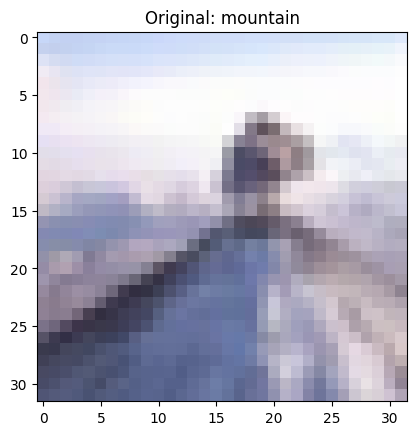

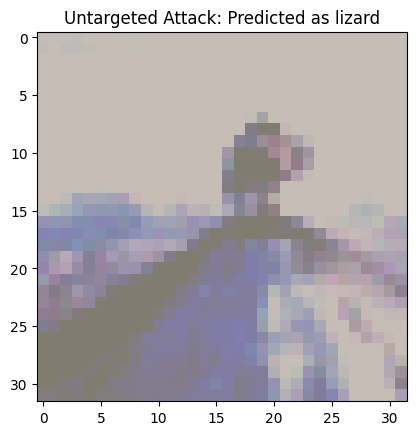

In [6]:
# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

def imshow(img, title):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.show()

# For untargeted attack
adv_images_untargeted = improved_pgd_attack(
    model,
    images, 
    labels,
    target_labels=None,
    epsilon=30/255,
    alpha=8/255,
    iters=50,
    random_start=True,
    untargeted=True
)

# Show original image
imshow(images[0], f"Original: {testset.classes[labels[0]]}")

# Show untargeted attack result
with torch.no_grad():
    outputs = model(adv_images_untargeted[0].unsqueeze(0))
    _, predicted = outputs.max(1)
    predicted_class = testset.classes[predicted.item()]
imshow(adv_images_untargeted[0], f"Untargeted Attack: Predicted as {predicted_class}")